In [71]:
import pandas as pd
import numpy as np

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading the Data

In [73]:
book= pd.read_csv("/content/drive/My Drive/Recommendation System/BX-Book-Ratings.csv")
book_isbn=pd.read_csv("/content/drive/My Drive/Recommendation System/BX-Books.csv")


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
book.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0.0
1,276726,155061224,5.0
2,276727,446520802,0.0
3,276729,052165615X,3.0
4,276729,521795028,6.0


In [75]:
book_details=book_isbn[["ISBN","Book-Title","Book-Author","Year-Of-Publication"]]
book_details.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication
0,195153448,Classical Mythology,Mark P. O. Morford,2002
1,2005018,Clara Callan,Richard Bruce Wright,2001
2,60973129,Decision in Normandy,Carlo D'Este,1991
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999


In [76]:
Merge_data = book.merge(book_details, on="ISBN", how = 'inner')

In [77]:
Merge_data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication
0,276725,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose,2002
1,2313,034545104X,5.0,Flesh Tones: A Novel,M. J. Rose,2002
2,6543,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose,2002
3,8680,034545104X,5.0,Flesh Tones: A Novel,M. J. Rose,2002
4,10314,034545104X,9.0,Flesh Tones: A Novel,M. J. Rose,2002


Data Visualization and Preprocessing

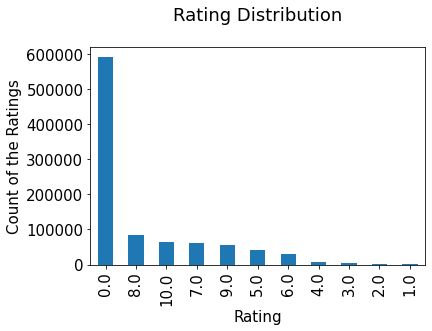

In [78]:
import matplotlib.pyplot as plt
# Rating Count
plt.rc("font", size=15)
Merge_data["Book-Rating"].value_counts(sort=True).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count of the Ratings')
plt.show()

In [79]:
Merge_data.shape

(941148, 6)

In [80]:
# Counting the number of rating in each book
rating_total_count = pd.DataFrame(Merge_data.groupby('ISBN')['Book-Rating'].count())
rating_total_count.sort_values('Book-Rating', ascending=False).head(10)

,Book-Rating
ISBN,
971880107,2264
316666343,1164
385504209,813
312195516,668
60928336,662
044023722X,595
142001740,555
067976402X,552
671027360,536


In [81]:
# Counting the number of rating given by each user
user_total_count = pd.DataFrame(Merge_data.groupby('User-ID')['Book-Rating'].count())
user_total_count.sort_values('Book-Rating', ascending=False).head(10)

,Book-Rating
User-ID,
11676,11147
198711,6456
153662,5817
98391,5779
35859,5646
212898,4290
278418,3997
76352,3329
110973,2974


In [82]:
# We need to make sure that the book has enough reviews from users and the users has also given enough reviews.

#Getting users who had given more than 100 ratings 
user_count = Merge_data['User-ID'].value_counts()
Merge_data = Merge_data[Merge_data['User-ID'].isin(user_count[user_count >= 100].index)]

#Getting books which have more than 100 ratings by the users
book_count = Merge_data['Book-Rating'].value_counts()
Merge_data = Merge_data[Merge_data['Book-Rating'].isin(book_count[book_count >= 100].index)]

In [83]:
Merge_data.shape

(543699, 6)

In [84]:
data=Merge_data[['User-ID','ISBN','Book-Rating','Book-Title']]
data.rename(columns = {'User-ID':'userid','Book-Rating':'bookrating','Book-Title':'booktitle'}, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [85]:
data.reset_index()

,index,userid,ISBN,bookrating,booktitle
0,2,6543,034545104X,0.0,Flesh Tones: A Novel
1,4,10314,034545104X,9.0,Flesh Tones: A Novel
2,5,23768,034545104X,0.0,Flesh Tones: A Novel
3,7,28523,034545104X,0.0,Flesh Tones: A Novel
4,14,77480,034545104X,8.0,Flesh Tones: A Novel
...,...,...,...,...,...
543694,941143,250764,440106575,0.0,HIDDEN FIRES
543695,941144,250764,451157516,0.0,Cheyenne (Fortunes West
543696,941145,250764,048623715X,0.0,Glamorous Movie Stars of the Thirties: Paper D...
543697,941146,250764,486256588,0.0,Schiaparelli Fashion Review: Paper Dolls in Fu...



Collaborative Filtering using k Nearest Neighbour

In [86]:
data1 = data.merge(rating_total_count, left_on = 'ISBN', right_on = 'ISBN', how = 'left')
data1.rename(columns = {'Book-Rating':'totalratings'}, inplace = True)
data1.head()

,userid,ISBN,bookrating,booktitle,totalratings
0,6543,034545104X,0.0,Flesh Tones: A Novel,53
1,10314,034545104X,9.0,Flesh Tones: A Novel,53
2,23768,034545104X,0.0,Flesh Tones: A Novel,53
3,28523,034545104X,0.0,Flesh Tones: A Novel,53
4,77480,034545104X,8.0,Flesh Tones: A Novel,53


In [87]:
data1.shape

(543699, 5)

In [88]:
threshold = 50
data1 = data1.query('totalratings >= @threshold')
data1.head()

,userid,ISBN,bookrating,booktitle,totalratings
0,6543,034545104X,0.0,Flesh Tones: A Novel,53
1,10314,034545104X,9.0,Flesh Tones: A Novel,53
2,23768,034545104X,0.0,Flesh Tones: A Novel,53
3,28523,034545104X,0.0,Flesh Tones: A Novel,53
4,77480,034545104X,8.0,Flesh Tones: A Novel,53


In [89]:
data1.shape

(100070, 5)

In [90]:
#Cosine Similarity

from scipy.sparse import csr_matrix
data1 = data1.drop_duplicates(['userid', 'booktitle'])
data_pivot = data1.pivot(index = 'booktitle', columns = 'userid', values = 'bookrating').fillna(0)
data1_mat = csr_matrix(data_pivot.values)

# kNN Model
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(data1_mat)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [91]:
#Testing
query_index = np.random.choice(data_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(data_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

368


In [92]:
data_pivot.index[query_index]

'Doomsday Book'

In [93]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(data_pivot.index[query_index]))
    else:
        print('{0}: {1}'.format(i, data_pivot.index[indices.flatten()[i]]))

Recommendations for Doomsday Book:

1: The Good Earth (Enriched Classics)
2: The Little Friend
3: What We Keep
4: Straight Man : A Novel (Vintage Contemporaries)
5: Welcome to Temptation


In [94]:
#Saving model
import pickle
pickle.dump(model_knn,open('/content/drive/MyDrive/Recommendation System/model_recom.pkl','wb'))

Deployment Using Flask Application

In [95]:
!pip install flask-ngrok

In [96]:
#Flask Application
from flask import Flask, request, jsonify, render_template
from flask_ngrok import run_with_ngrok

In [97]:
books_list=list(data_pivot.index)

In [98]:
 with open("/content/drive/MyDrive/Recommendation System/book_list.txt", "wb") as fp:
   pickle.dump(books_list, fp)

In [99]:
books_list

['16 Lighthouse Road',
 '1984',
 '1st to Die: A Novel',
 '2010: Odyssey Two',
 '204 Rosewood Lane',
 '24 Hours',
 '2nd Chance',
 '3rd Degree',
 '4 Blondes',
 '84 Charing Cross Road',
 'A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))',
 'A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash',
 'A Bend in the Road',
 'A Case of Need',
 'A Child Called \\It\\": One Child\'s Courage to Survive"',
 'A Civil Action',
 'A Cold Heart (Alex Delaware Novels (Paperback))',
 'A Cold Heart: An Alex Delaware Novel',
 'A Confederacy of Dunces',
 'A Confederacy of Dunces (Evergreen Book)',
 'A Cry In The Night',
 "A Cup of Tea (Ballantine Reader's Circle)",
 'A Dangerous Fortune',
 'A Darkness More Than Night',
 'A Day Late and a Dollar Short',
 'A Fine Balance',
 'A Game of Thrones (A Song of Ice and Fire',
 'A Girl Named Zippy: Growing Up Small in Mooreland Indiana (Today Show Book Club #3)',
 'A Great Deliverance',
 'A Heartbreaking Wor

In [100]:
# Function to get the Index of the Book
def get_index(req):
  count=0
  for i in books_list:
    count+=1
    alpha=i.lower()
    
    if alpha==req:
      return (count-1)
    else:
      continue

In [108]:
app = Flask(__name__,template_folder='/content/drive/MyDrive/Recommendation System/templates')
model = pickle.load(open('/content/drive/MyDrive/Recommendation System/model_recom.pkl', 'rb'))
run_with_ngrok(app)

@app.route('/')
def home():
    return render_template('book_index.html')

@app.route('/predict',methods=['POST'])
def predict():
  if request.method == 'POST':
    message = str(request.form['message'])
    inp=str(message)
    ind=get_index(message)
    if bool(ind)== True:
      distances, indices = model.kneighbors(data_pivot.iloc[ind,:].values.reshape(1, -1), n_neighbors = 6)
      Listofbooks=[]
      for i in range(0, len(distances.flatten())):
        Listofbooks.append(data_pivot.index[indices.flatten()[i]])
      return render_template('book_index.html',prediction_text = 'Recommended Books for: {}'.format(Listofbooks[0]),
                             prediction_text1 = '1]  {}'.format(Listofbooks[1]),
                             prediction_text2 = '2]  {}'.format(Listofbooks[2]),
                             prediction_text3 = '3]  {}'.format(Listofbooks[3]),
                             prediction_text4 = '4]  {}'.format(Listofbooks[4]),
                             prediction_text5 = '5]  {}'.format(Listofbooks[5]))
    elif bool(ind)== False:
      return render_template('book_index.html',prediction_text = 'Sorry!! We Do not have that book in our Dataset')




if __name__ == "__main__":
  app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://cc7a64ebe0be.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [17/Nov/2020 13:12:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2020 13:12:38] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [17/Nov/2020 13:12:38] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [17/Nov/2020 13:12:47] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2020 13:12:47] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [17/Nov/2020 13:13:18] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2020 13:13:18] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [17/Nov/2020 13:13:25] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2020 13:13:25] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [17/Nov/2020 13:14:07] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2020 13:14:08] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [17/Nov/2020 13:15:29] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2020 13:15:30] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [17/Nov/2020 13:16:01] "POST 